In [22]:
## EDA the dataset 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


data = pd.read_csv('/home/ram/sentiment_mlops/data/raw/YoutubeCommentsDataSet.csv')

In [6]:
data.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


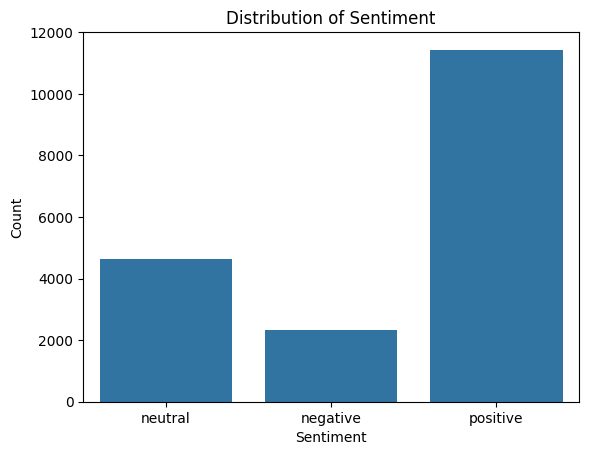

In [7]:
## check the positive and negative , neutral comments distribution
sns.countplot(x='Sentiment', data=data)
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


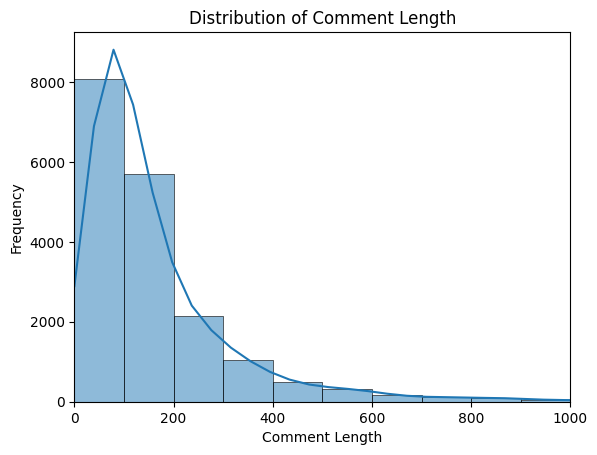

In [14]:
## check the length of comments distribution
# Ensure comments are strings and handle missing values safely
data['Comment'] = data['Comment'].fillna('').astype(str)
data['CommentLength'] = data['Comment'].str.len()
# Use 100-unit bins and set x-ticks at 0,100,200,...
bin_width = 100
max_len = int(data['CommentLength'].max()) if not data['CommentLength'].empty else 0
sns.histplot(data['CommentLength'], bins=range(0, 1100, bin_width), kde=True)
plt.title('Distribution of Comment Length')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()

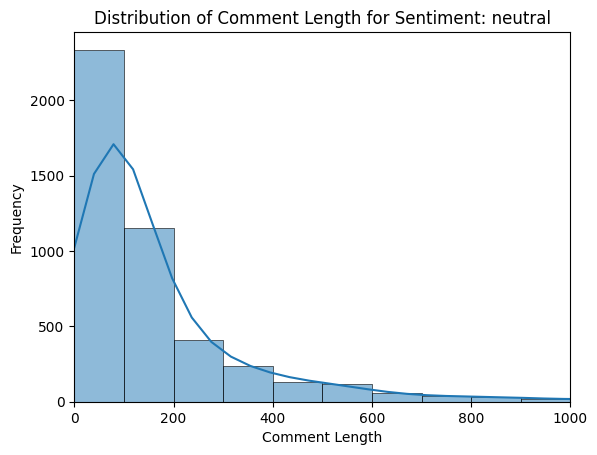

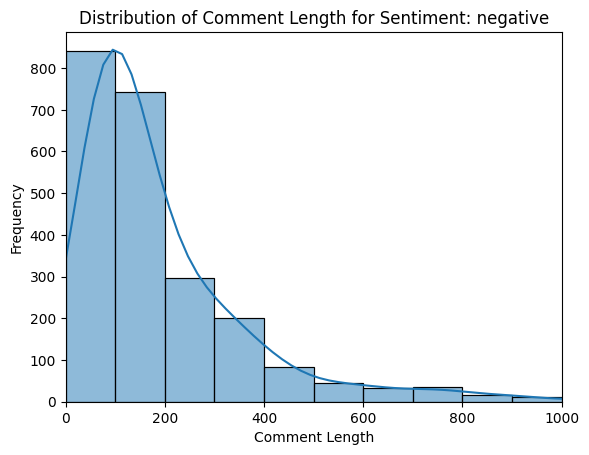

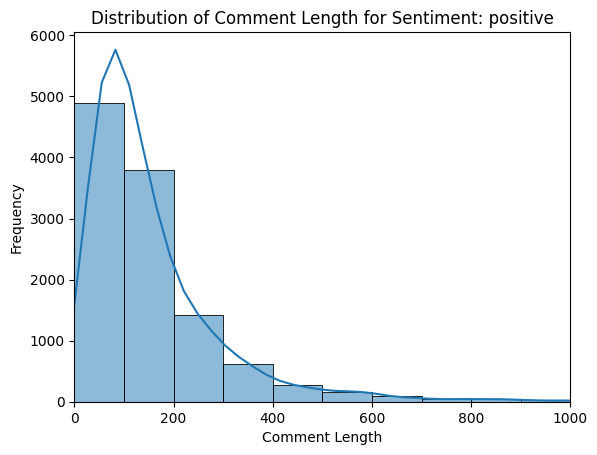

In [16]:
## distribution of comments based on the sentiment in 3 diffrent graphs
sentiments = data['Sentiment'].unique()
for sentiment in sentiments:
    subset = data[data['Sentiment'] == sentiment]
    sns.histplot(subset['CommentLength'], bins=range(0, 1100, bin_width), kde=True)
    plt.title(f'Distribution of Comment Length for Sentiment: {sentiment}')
    plt.xlabel('Comment Length')
    plt.ylabel('Frequency')
    plt.xlim(0, 1000)
    plt.show()
    

Silhouette Score (raw embeddings only): 0.0148
Running t-SNE on raw embeddings...


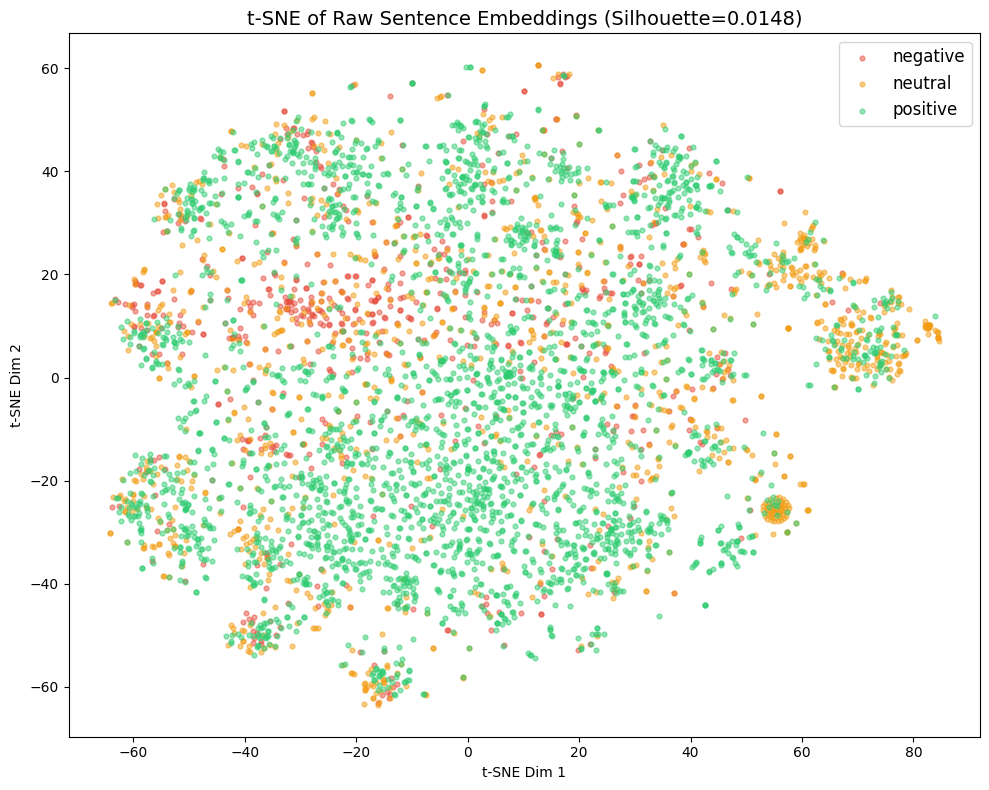


Compare this with the Embeddings+VADER plot in the next cells.
If clusters overlap heavily here, the sentence embeddings alone
lack sentiment signal — which is expected since MiniLM is trained
for semantic similarity, not sentiment polarity.


In [29]:
## Visualize raw embeddings (before VADER / SMOTE) — baseline cluster view
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Sample for speed (use all if small enough)
n = len(embeddings)
max_samples = 5000
if n > max_samples:
    idx = np.random.RandomState(42).choice(n, size=max_samples, replace=False)
else:
    idx = np.arange(n)

emb_sample = embeddings[idx]
labels_sample = df['label'].values[idx]

# Silhouette on raw embeddings
sil_raw = silhouette_score(emb_sample, labels_sample)
print(f"Silhouette Score (raw embeddings only): {sil_raw:.4f}")

# t-SNE projection
print("Running t-SNE on raw embeddings...")
tsne_raw = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d_raw = tsne_raw.fit_transform(emb_sample)

inv_label_map = {v: k for k, v in label_map.items()}

raw_plot_df = pd.DataFrame({
    "x": X_2d_raw[:, 0],
    "y": X_2d_raw[:, 1],
    "Sentiment": [inv_label_map[l] for l in labels_sample]
})

colors = {"positive": "#2ecc71", "neutral": "#f39c12", "negative": "#e74c3c"}

fig, ax = plt.subplots(figsize=(10, 8))
for sentiment, group in raw_plot_df.groupby("Sentiment"):
    ax.scatter(group["x"], group["y"], label=sentiment, color=colors[sentiment], alpha=0.5, s=12)

ax.set_title(f"t-SNE of Raw Sentence Embeddings (Silhouette={sil_raw:.4f})", fontsize=14)
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("\nCompare this with the Embeddings+VADER plot in the next cells.")
print("If clusters overlap heavily here, the sentence embeddings alone")
print("lack sentiment signal — which is expected since MiniLM is trained")
print("for semantic similarity, not sentiment polarity.")

In [27]:
import re
import json
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os

# 1. CONFIGURATION
RAW_DATA_PATH = "/home/ram/sentiment_mlops/data/raw/YoutubeCommentsDataSet.csv"
PROCESSED_PATH = "/home/ram/sentiment_mlops/data/processed/"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

os.makedirs(PROCESSED_PATH, exist_ok=True)

# 2. LOAD & CLEAN DATA
print("Loading data...")
df = pd.read_csv(RAW_DATA_PATH)
df['Comment'] = df['Comment'].fillna('').astype(str)

# Keep raw text for VADER (it works best on uncleaned text)
df['raw_comment'] = df['Comment']

# Text preprocessing for embeddings
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)   # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)      # Remove special chars
    text = re.sub(r'\s+', ' ', text).strip()          # Collapse whitespace
    return text

df['Comment'] = df['Comment'].apply(clean_text)
df = df[df['Sentiment'].isin(['positive', 'negative', 'neutral'])]

# Encode Labels
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label'] = df['Sentiment'].map(label_map)
print(f"Original Class Distribution:\n{df['label'].value_counts()}")

# 3. GENERATE EMBEDDINGS (semantic meaning)
print("\n[1/2] Generating sentence embeddings...")
st_model = SentenceTransformer(EMBEDDING_MODEL)
embeddings = st_model.encode(df['Comment'].tolist(), show_progress_bar=True)

# 4. EXTRACT VADER SENTIMENT FEATURES (sentiment signal)
print("[2/2] Extracting VADER sentiment features...")
analyzer = SentimentIntensityAnalyzer()
vader_features = []
for text in df['raw_comment']:
    scores = analyzer.polarity_scores(text)
    vader_features.append([scores['compound'], scores['pos'], scores['neg'], scores['neu']])
vader_features = np.array(vader_features)

# 5. COMBINE: Embeddings (384-d) + VADER (4-d) = 388-d feature vector
# Scale VADER features so they have similar magnitude to embeddings
scaler = StandardScaler()
vader_scaled = scaler.fit_transform(vader_features)
combined_features = np.hstack([embeddings, vader_scaled])

print(f"\nFeature dimensions:")
print(f"  Embeddings:  {embeddings.shape}")
print(f"  VADER:       {vader_features.shape}")
print(f"  Combined:    {combined_features.shape}")

# 6. SPLIT DATA (Before SMOTE!)
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# 7. APPLY SMOTE (Balance the Training Data)
print("\nApplying SMOTE to Training Data...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(f"Balanced Class Distribution:\n{y_train_balanced.value_counts()}")

# 8. SAVE ARTIFACTS
print("\nSaving processed data...")
np.save(os.path.join(PROCESSED_PATH, "train_vectors.npy"), X_train_balanced)
np.save(os.path.join(PROCESSED_PATH, "train_labels.npy"), y_train_balanced)
np.save(os.path.join(PROCESSED_PATH, "test_vectors.npy"), X_test)
np.save(os.path.join(PROCESSED_PATH, "test_labels.npy"), y_test)

# Save metadata for inference
metadata = {
    "label_map": label_map,
    "embedding_model": EMBEDDING_MODEL,
    "feature_dim": combined_features.shape[1],
    "features": "sentence_embeddings(384) + vader_scaled(4)"
}
with open(os.path.join(PROCESSED_PATH, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

print("Preprocessing Complete. Ready for Training.")

Loading data...
Original Class Distribution:
label
0    11432
1     4638
2     2338
Name: count, dtype: int64

[1/2] Generating sentence embeddings...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 337.34it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 576/576 [00:34<00:00, 16.92it/s]


[2/2] Extracting VADER sentiment features...

Feature dimensions:
  Embeddings:  (18408, 384)
  VADER:       (18408, 4)
  Combined:    (18408, 388)

Applying SMOTE to Training Data...
Balanced Class Distribution:
label
0    9146
2    9146
1    9146
Name: count, dtype: int64

Saving processed data...
Preprocessing Complete. Ready for Training.


=== Shape Comparison ===
Before SMOTE: X_train=(14726, 388), y_train=(14726,)
After  SMOTE: X_train_balanced=(27438, 388), y_train_balanced=(27438,)
Test (untouched): X_test=(3682, 388), y_test=(3682,)

          Before SMOTE  After SMOTE  Synthetic Added
label                                               
negative          1870         9146             7276
neutral           3710         9146             5436
positive          9146         9146                0



=== Silhouette Score (higher = better separation): 0.0638 ===

Running t-SNE (2D projection)...


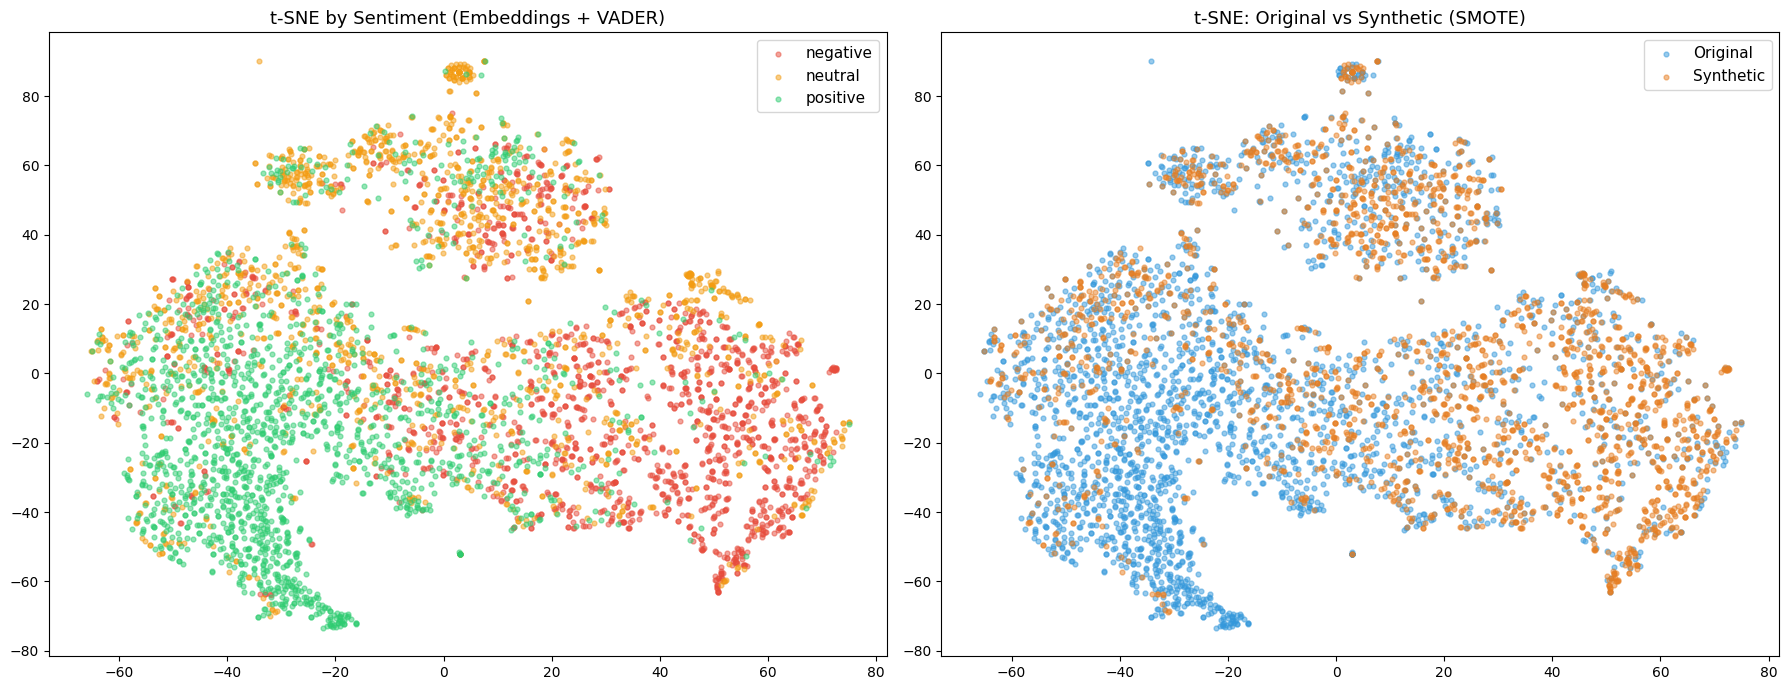

In [28]:
## Inspect improved feature space after SMOTE
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

inv_label_map = {v: k for k, v in label_map.items()}

# --- 1. Shape & class comparison ---
print("=== Shape Comparison ===")
print(f"Before SMOTE: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"After  SMOTE: X_train_balanced={X_train_balanced.shape}, y_train_balanced={y_train_balanced.shape}")
print(f"Test (untouched): X_test={X_test.shape}, y_test={y_test.shape}")

before = y_train.value_counts().rename(index=inv_label_map)
after  = y_train_balanced.value_counts().rename(index=inv_label_map)
comparison = pd.DataFrame({"Before SMOTE": before, "After SMOTE": after})
comparison["Synthetic Added"] = comparison["After SMOTE"] - comparison["Before SMOTE"]
print(f"\n{comparison}")

# --- 2. Silhouette score (cluster separability metric) ---
# Higher = better separated clusters (-1 to 1 scale)
# Sample for speed
sample_idx = np.random.RandomState(42).choice(len(X_train_balanced), size=min(5000, len(X_train_balanced)), replace=False)
sil = silhouette_score(X_train_balanced[sample_idx], y_train_balanced.iloc[sample_idx])
print(f"\n=== Silhouette Score (higher = better separation): {sil:.4f} ===")

# --- 3. t-SNE visualization ---
print("\nRunning t-SNE (2D projection)...")
n_original = X_train.shape[0]
sample_type = ["Original"] * n_original + ["Synthetic"] * (X_train_balanced.shape[0] - n_original)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_train_balanced[sample_idx])

plot_df = pd.DataFrame({
    "x": X_2d[:, 0], "y": X_2d[:, 1],
    "label": [inv_label_map[l] for l in y_train_balanced.iloc[sample_idx]],
    "type": [sample_type[i] for i in sample_idx]
})

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

colors = {"positive": "#2ecc71", "neutral": "#f39c12", "negative": "#e74c3c"}
for label, group in plot_df.groupby("label"):
    axes[0].scatter(group["x"], group["y"], label=label, color=colors[label], alpha=0.5, s=12)
axes[0].set_title("t-SNE by Sentiment (Embeddings + VADER)", fontsize=13)
axes[0].legend(fontsize=11)

for t, group in plot_df.groupby("type"):
    c = "#3498db" if t == "Original" else "#e67e22"
    axes[1].scatter(group["x"], group["y"], label=t, color=c, alpha=0.5, s=12)
axes[1].set_title("t-SNE: Original vs Synthetic (SMOTE)", fontsize=13)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()